In [17]:
import math, random, numpy as np, pandas as pd, torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
from acpi import ACPI
from acpi.utils import compute_coverage
import os

# ------------------
# Data utilities
# ------------------
def read_data(file):
    # Use a try-except block for robust file reading
    try:
        df = pd.read_csv(file, parse_dates=["datetime"]).set_index("datetime").sort_index()
    except FileNotFoundError:
        print(f"Error: The file '{file}' was not found.")
        print("Please ensure you have a 'data/train.csv' file in your directory.")
        # Create a dummy file to allow the script to run without error
        print("Creating a dummy 'data/train.csv' for demonstration purposes.")
        dummy_dates = pd.to_datetime(pd.date_range(start='1/1/2011', periods=1000, freq='H'))
        dummy_data = {
            'datetime': dummy_dates,
            'count': np.random.randint(5, 500, size=1000)
        }
        dummy_df = pd.DataFrame(dummy_data)
        if not os.path.exists('data'):
            os.makedirs('data')
        dummy_df.to_csv('data/train.csv', index=False)
        df = pd.read_csv("data/train.csv", parse_dates=["datetime"]).set_index("datetime").sort_index()

    for bcol in ["holiday", "workingday"]:
        if bcol in df.columns:
            df[bcol] = df[bcol].astype(bool)
    df = df.fillna(method='ffill').fillna(method='bfill')
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

def create_sequences(data, context_length, prediction_length):
    X, y = [], []
    for i in range(len(data) - context_length - prediction_length + 1):
        X.append(data[i:i+context_length])
        y.append(data[i+context_length:i+context_length+prediction_length])
    return np.array(X), np.array(y)

def prepare_acpi_data(data, context_length, prediction_length=1, test_split=0.3, cal_split=0.5):
    X, y = create_sequences(data, context_length, prediction_length)
    n_test = int(len(X) * test_split)
    X_temp, X_test = X[:-n_test], X[-n_test:]
    y_temp, y_test = y[:-n_test], y[-n_test:]
    n_cal = int(len(X_temp) * cal_split)
    X_train, X_cal = X_temp[:-n_cal], X_temp[-n_cal:]
    y_train, y_cal = y_temp[:-n_cal], y_temp[-n_cal:]
    return X_train, X_cal, X_test, y_train.flatten(), y_cal.flatten(), y_test.flatten()

# ------------------
# Model definitions
# ------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerTimeSeriesModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, dim_feedforward,
                 dropout, context_length, prediction_length, output_variance=True):
        super().__init__()
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.output_variance = output_variance
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=context_length)
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                           dim_feedforward=dim_feedforward,
                                           dropout=dropout, batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)
        out_dim = prediction_length * (2 if output_variance else 1)
        self.head = nn.Linear(d_model, out_dim)
    def forward(self, x):
        h = self.input_proj(x)
        h = self.pos_enc(h)
        h = self.encoder(h)
        h_last = h[:, -1, :]
        out = self.head(h_last)
        if self.output_variance:
            mean, log_var = out.chunk(2, dim=-1)
            mean = mean.view(-1, self.prediction_length)
            log_var = log_var.view(-1, self.prediction_length).clamp(-7, 7)
            return mean, log_var
        return out.view(-1, self.prediction_length), None

class TransformerACPIWrapper:
    def __init__(self, transformer_model, device):
        self.model = transformer_model.eval()
        self.device = device
    def predict(self, X):
        with torch.no_grad():
            t = torch.as_tensor(X, dtype=torch.float32, device=self.device).unsqueeze(-1)
            mean, _ = self.model(t)
            return mean.cpu().numpy().flatten()

# ------------------
# Training function
# ------------------
def train_transformer(train_series, context_length, prediction_length,
                      device, epochs=5, batch_size=32, lr=1e-3, seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    model = TransformerTimeSeriesModel(
        input_size=1, d_model=64, nhead=4, num_layers=2,
        dim_feedforward=128, dropout=0.1,
        context_length=context_length, prediction_length=prediction_length,
        output_variance=True).to(device)
    X, y = create_sequences(train_series, context_length, prediction_length)
    X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
    y_t = torch.tensor(y, dtype=torch.float32)
    loader = DataLoader(TensorDataset(X_t, y_t), batch_size=batch_size, shuffle=True)
    opt = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        for bx, by in loader:
            bx, by = bx.to(device), by.to(device)
            opt.zero_grad()
            mean_pred, log_var = model(bx)
            var = torch.exp(log_var)
            loss = 0.5 * (torch.log(2 * math.pi * var) + (by - mean_pred)**2 / var).mean()
            loss.backward()
            opt.step()
    return model

# ----------------------------
# Counterfactual Generator
# ----------------------------

def interval_miss_margin(y_true, y_lower, y_upper):
    # Positive if outside, negative if still inside (distance to nearest boundary)
    if y_true < y_lower:
        return float(y_lower - y_true)
    if y_true > y_upper:
        return float(y_true - y_upper)
    return -float(min(y_true - y_lower, y_upper - y_true))

def project(x, lower=None, upper=None, immutable_mask=None, x_orig=None):
    if lower is not None:
        x = torch.maximum(x, torch.as_tensor(lower, device=x.device, dtype=x.dtype))
    if upper is not None:
        x = torch.minimum(x, torch.as_tensor(upper, device=x.device, dtype=x.dtype))
    if immutable_mask is not None and x_orig is not None:
        # immutable_mask==1 means cannot change
        x = torch.where(torch.as_tensor(immutable_mask, device=x.device, dtype=torch.bool),
                        torch.as_tensor(x_orig, device=x.device, dtype=x.dtype), x)
    return x

In [18]:
# ------------------
# Main experiment setup
# ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_df = read_data("data/train.csv")
target_col = "count"
series = train_df[target_col].values.astype(float)

context_length = 24
prediction_length = 1
alpha = 0.1
target_coverage = 1 - alpha
epochs_per_run = 5
tolerance = 0.0

coverages = []
run_info = []


#Train the model

seed = 42
model = train_transformer(series, context_length, prediction_length,
                          device, epochs=epochs_per_run, seed=seed)
X_tr, X_cal, X_test, y_tr, y_cal, y_test = prepare_acpi_data(series, context_length, prediction_length)
wrapper = TransformerACPIWrapper(model, device)
acpi = ACPI(model_cali=wrapper, n_estimators=100, max_depth=20, min_node_size=10)
acpi.fit(X_cal, y_cal, nonconformity_func=None)
acpi.fit_calibration(X_cal, y_cal, nonconformity_func=None, quantile=1-alpha, only_qrf=True)
y_lower, y_upper = acpi.predict_pi(X_test, method='qrf')
coverage = compute_coverage(y_test, y_lower, y_upper)
coverages.append(coverage)

C:\Users\joobzm\AppData\Local\Temp\ipykernel_40956\884683069.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
C:\Users\joobzm\Desktop\TDK\ACPI\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
100%|██████████| 50/50 [03:02<00:00,  3.64s/it]


In [41]:
class CounterfactualGenerator:
    """
    Generates a counterfactual that makes the conformal prediction interval miss y (increase miss margin).
    """
    def __init__(self, transformer_model, acpi_predictor, device):
        self.model = transformer_model.eval()
        self.acpi = acpi_predictor
        self.device = device

    @staticmethod
    def _interval_miss_margin(y_true, y_lower, y_upper):
        if y_true < y_lower:
            return y_lower - y_true
        if y_true > y_upper:
            return y_true - y_upper
        return -min(y_true - y_lower, y_upper - y_true)

    def generate(self, x_orig, y_orig, target_margin=0.5, lambda_l1=0.5, lambda_smooth=0.05,
                 max_iter=400, early_patience=60, n_starts=5, immutable_mask=None,
                 lower_bounds=0.0, upper_bounds=None, adapt_lambda=True,
                 target_sparsity_ratio=0.2, sparsity_tolerance=0.05,
                 grad_clip=5.0, seed=0):
        import torch, numpy as np
        torch.manual_seed(seed)
        np.random.seed(seed)
        x_orig = np.asarray(x_orig, dtype=np.float32)

        y_l0, y_u0 = self.acpi.predict_pi(x_orig.reshape(1, -1))
        y_lower_o = float(np.asarray(y_l0).reshape(-1)[0])
        y_upper_o = float(np.asarray(y_u0).reshape(-1)[0])

        if not (y_lower_o <= y_orig <= y_upper_o):
            return {
                "status": "skip_not_covered",
                "original_interval": (y_lower_o, y_upper_o)
            }

        best = None
        for start in range(n_starts):
            noise = (0.01 * np.std(x_orig).astype(np.float32)) * np.random.randn(*x_orig.shape).astype(np.float32)
            x0 = (x_orig + noise).astype(np.float32)
            x_cf = torch.tensor(x0, device=self.device, dtype=torch.float32, requires_grad=True)
            x_orig_t = torch.tensor(x_orig, device=self.device, dtype=torch.float32)
            opt = torch.optim.Adam([x_cf], lr=0.01)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=30)

            best_margin = -1e9
            best_state = None
            it_since_improve = 0
            cur_lambda_l1 = lambda_l1

            for it in range(max_iter):
                opt.zero_grad()
                mean_pred, _ = self.model(x_cf.unsqueeze(0).unsqueeze(-1))
                with torch.no_grad():
                    y_l, y_u = self.acpi.predict_pi(x_cf.detach().cpu().numpy().reshape(1, -1))
                    y_l = float(np.asarray(y_l).reshape(-1)[0])
                    y_u = float(np.asarray(y_u).reshape(-1)[0])
                    margin = self._interval_miss_margin(y_orig, y_l, y_u)

                if margin < 0:
                    midpoint = (y_l + y_u) / 2.0
                    direction = 1.0 if y_orig < midpoint else -1.0
                    validity_loss = -direction * mean_pred
                else:
                    if y_orig < y_l:
                        validity_loss = -(mean_pred - y_orig)
                    else:
                        validity_loss = (mean_pred - y_orig)

                diff = x_cf - x_orig_t
                l1 = torch.norm(diff, p=1)
                smooth = torch.mean(torch.abs(diff[1:] - diff[:-1])) if diff.numel() > 1 else torch.tensor(0.0, device=self.device)
                loss = validity_loss + cur_lambda_l1 * l1 + lambda_smooth * smooth
                loss.backward()
                torch.nn.utils.clip_grad_norm_([x_cf], grad_clip)
                opt.step()

                # Projection
                if lower_bounds is not None:
                    x_cf.data = torch.maximum(x_cf.data, torch.as_tensor(lower_bounds, device=self.device, dtype=x_cf.dtype))
                if upper_bounds is not None:
                    x_cf.data = torch.minimum(x_cf.data, torch.as_tensor(upper_bounds, device=self.device, dtype=x_cf.dtype))
                if immutable_mask is not None:
                    imm = torch.as_tensor(immutable_mask, device=self.device, dtype=torch.bool)
                    x_cf.data = torch.where(imm, x_orig_t, x_cf.data)

                if margin > best_margin:
                    best_margin = margin
                    best_state = {
                        "x": x_cf.detach().cpu().numpy().copy(),
                        "margin": margin,
                        "interval": (y_l, y_u),
                        "iter": it
                    }
                    it_since_improve = 0
                else:
                    it_since_improve += 1

                if (it + 1) % 25 == 0 and adapt_lambda:
                    changed_ratio = float((diff.detach().abs() > 1e-3).sum().item()) / diff.numel()
                    if changed_ratio > target_sparsity_ratio + sparsity_tolerance:
                        cur_lambda_l1 *= 1.2
                    elif changed_ratio < target_sparsity_ratio - sparsity_tolerance:
                        cur_lambda_l1 *= 0.9

                if best_margin >= target_margin or it_since_improve >= early_patience:
                    break
                scheduler.step(float(loss.detach().cpu()))

            if best_state is not None:
                candidate = {
                    "start": start,
                    "x_cf": best_state["x"],
                    "final_margin": best_state["margin"],
                    "interval_cf": best_state["interval"],
                    "iterations": best_state["iter"],
                    "l1": float(np.abs(best_state["x"] - x_orig).sum()),
                    "changed_ratio": float(np.mean(np.abs(best_state["x"] - x_orig) > 1e-3))
                }
                if (best is None or
                    candidate["final_margin"] > best["final_margin"] or
                    (candidate["final_margin"] == best["final_margin"] and candidate["l1"] < best["l1"])):
                    best = candidate

        if best is None or best["final_margin"] < 0:
            return {
                "status": "fail_no_counterfactual",
                "original_interval": (y_lower_o, y_upper_o)
            }

        return {
            "status": "success",
            "original_interval": (y_lower_o, y_upper_o),
            "counterfactual_interval": best["interval_cf"],
            "final_margin": best["final_margin"],
            "l1": best["l1"],
            "changed_ratio": best["changed_ratio"],
            "iterations": best["iterations"],
            "x_cf": best["x_cf"],
            "y_true": float(y_orig),
            "x_orig": x_orig
        }

    def plot_counterfactual(self, result, show=True):
        import matplotlib.pyplot as plt
        if result.get("status") != "success":
            print("Nothing to plot (status=", result.get("status"), ")")
            return
        x_orig = result["x_orig"]
        x_cf = result["x_cf"]
        y_true = result["y_true"]
        (y_l0, y_u0) = result["original_interval"]
        (y_lc, y_uc) = result["counterfactual_interval"]

        fig, axes = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
        ax = axes[0]
        ax.plot(x_orig, label="orig sequence", color="C0")
        ax.plot(x_cf, label="counterfactual", color="C1")
        ax.set_ylabel("Value")
        ax.legend()
        ax.set_title("Input sequence")

        ax2 = axes[1]
        ax2.axhspan(y_l0, y_u0, color="C0", alpha=0.15, label="orig PI")
        ax2.axhspan(y_lc, y_uc, color="C1", alpha=0.15, label="cf PI")
        ax2.axhline(y_true, color="k", linestyle="--", label="true y")
        ax2.scatter([len(x_orig)-1], [y_true], color="k")
        ax2.set_ylabel("y / intervals")
        ax2.set_title(f"Intervals vs y (margin={result['final_margin']:.3f})")
        ax2.legend()
        axes[-1].set_xlabel("Time index")
        plt.tight_layout()
        if show:
            plt.show()
        return fig

In [46]:
class ModelBasedCounterfactualGenerator:
    """
    Enhanced differentiable counterfactual generator.
    """
    def __init__(self, transformer_model, device, alpha=0.1):
        import scipy.stats as _scistats
        self.model = transformer_model.eval()
        self.device = device
        self.alpha = alpha
        self.z = float(_scistats.norm.ppf(1 - alpha / 2.0))

    @staticmethod
    def _project(x, lower=None, upper=None, immutable_mask=None, x_orig=None):
        if lower is not None:
            x.data = torch.maximum(x.data, torch.as_tensor(lower, device=x.device, dtype=x.dtype))
        if upper is not None:
            x.data = torch.minimum(x.data, torch.as_tensor(upper, device=x.device, dtype=x.dtype))
        if immutable_mask is not None and x_orig is not None:
            imm = torch.as_tensor(immutable_mask, device=x.device, dtype=torch.bool)
            x_orig_t = torch.as_tensor(x_orig, device=x.device, dtype=x.dtype)
            x.data = torch.where(imm, x_orig_t, x.data)
        return x

    def predict_interval(self, x_seq):
        x_t = torch.as_tensor(x_seq, dtype=torch.float32, device=self.device).unsqueeze(0).unsqueeze(-1)
        with torch.no_grad():
            mean, log_var = self.model(x_t)
        mean = mean.squeeze(0)[0].item()
        std = torch.exp(0.5 * log_var.squeeze(0)[0]).item()
        return (mean - self.z * std, mean + self.z * std), mean, std

    def generate(self,
                 x_orig,
                 y_true,
                 target_margin=0.5,
                 lambda_l1=0.1,
                 lambda_smooth=0.01,
                 lambda_var=0.0,
                 max_iter=800,
                 early_patience=120,
                 n_starts=12,
                 immutable_mask=None,
                 lower_bounds=0.0,
                 upper_bounds=None,
                 adapt_lambda=True,
                 target_sparsity_ratio=0.15,
                 sparsity_tolerance=0.05,
                 grad_clip=5.0,
                 lr=0.02,
                 strategy="auto",   # "auto" | "up" | "down"
                 seed=0,
                 log_every=50):
        """
        Returns dict with diagnostics. margin = |mean - y| - z*std
        """
        import torch, numpy as np, math
        torch.manual_seed(seed)
        np.random.seed(seed)
        x_orig = np.asarray(x_orig, dtype=np.float32)
        best = None
        direction_set = [1.0] if strategy == "up" else ([-1.0] if strategy == "down" else [1.0, -1.0])

        for start in range(n_starts):
            for direction in direction_set:
                noise_scale = 0.01 * (np.std(x_orig) + 1e-6)
                x0 = x_orig + noise_scale * np.random.randn(*x_orig.shape).astype(np.float32)
                x_cf = torch.tensor(x0, device=self.device, dtype=torch.float32, requires_grad=True)
                x_orig_t = torch.tensor(x_orig, device=self.device, dtype=torch.float32)
                opt = torch.optim.Adam([x_cf], lr=lr)
                sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max_iter, eta_min=lr * 0.05)

                best_margin_local = -1e9
                patience_counter = 0
                cur_lambda_l1 = lambda_l1
                activated_var_penalty = False

                for it in range(max_iter):
                    opt.zero_grad()
                    mean_pred, log_var = self.model(x_cf.unsqueeze(0).unsqueeze(-1))
                    mean_pred = mean_pred.squeeze(0)[0]
                    std_pred = torch.exp(0.5 * log_var.squeeze(0)[0])

                    # Raw margin
                    margin = torch.abs(mean_pred - y_true) - self.z * std_pred

                    # Directional push (helps escape flat region)
                    directional_term = -direction * (mean_pred - y_true)

                    # Shaped margin (softplus for smoother gradients when negative)
                    shaped = torch.nn.functional.softplus(margin)

                    # Base validity: encourage increasing margin directly
                    validity_loss = -(margin + 0.1 * shaped) + 0.05 * directional_term

                    # Activate variance penalty if mean shift large but margin not improving
                    if not activated_var_penalty and torch.abs(mean_pred - y_true) > 0.5 * target_margin:
                        activated_var_penalty = True
                        lambda_var_eff = max(lambda_var, 0.01)
                    else:
                        lambda_var_eff = lambda_var if activated_var_penalty else 0.0

                    var_pen = lambda_var_eff * std_pred  # shrink predictive std

                    diff = x_cf - x_orig_t
                    l1 = torch.norm(diff, p=1)
                    smooth = torch.mean(torch.abs(diff[1:] - diff[:-1])) if diff.numel() > 1 else torch.tensor(0.0, device=self.device)

                    loss = validity_loss + cur_lambda_l1 * l1 + lambda_smooth * smooth + var_pen
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_([x_cf], grad_clip)
                    opt.step()
                    self._project(x_cf, lower=lower_bounds, upper=upper_bounds,
                                  immutable_mask=immutable_mask, x_orig=x_orig_t)
                    sched.step()

                    margin_val = float(margin.detach().cpu())
                    mean_val = float(mean_pred.detach().cpu())
                    std_val = float(std_pred.detach().cpu())

                    improved = margin_val > best_margin_local + 1e-6
                    if improved:
                        best_margin_local = margin_val
                        patience_counter = 0
                        candidate = {
                            "x_cf": x_cf.detach().cpu().numpy().copy(),
                            "final_margin": margin_val,
                            "pred_mean": mean_val,
                            "pred_std": std_val,
                            "iter": it,
                            "l1": float(np.abs(x_cf.detach().cpu().numpy() - x_orig).sum()),
                            "changed_ratio": float(np.mean(np.abs(x_cf.detach().cpu().numpy() - x_orig) > 1e-3)),
                            "start": start,
                            "direction": direction,
                            "lambda_l1_final": cur_lambda_l1,
                            "lambda_var_used": lambda_var_eff
                        }
                        if (best is None or
                            candidate["final_margin"] > best["final_margin"] or
                            (candidate["final_margin"] == best["final_margin"] and candidate["l1"] < best["l1"])):
                            best = candidate
                    else:
                        patience_counter += 1

                    if (it + 1) % log_every == 0:
                        print(f"[start {start} dir {direction:+}] it={it+1} margin={margin_val:.4f} "
                              f"mean={mean_val:.3f} std={std_val:.3f} l1={float(l1):.3f} "
                              f"chg={(diff.abs()>1e-3).float().mean().item():.2f} λ1={cur_lambda_l1:.3f}")

                    if (it + 1) % 40 == 0 and adapt_lambda:
                        changed_ratio = float((diff.detach().abs() > 1e-3).sum().item()) / diff.numel()
                        if changed_ratio > target_sparsity_ratio + sparsity_tolerance:
                            cur_lambda_l1 *= 1.25
                        elif changed_ratio < target_sparsity_ratio - sparsity_tolerance:
                            cur_lambda_l1 *= 0.85
                            cur_lambda_l1 = max(cur_lambda_l1, 1e-4)

                    if best_margin_local >= target_margin:
                        break
                    if patience_counter >= early_patience:
                        break

        if not best or best["final_margin"] < 0:
            return {
                "status": "fail_no_counterfactual",
                "final_margin": None,
                "interval_cf_model": None
            }

        interval = (
            best["pred_mean"] - self.z * best["pred_std"],
            best["pred_mean"] + self.z * best["pred_std"]
        )
        outside = not (interval[0] <= y_true <= interval[1])
        best.update({
            "status": "success_outside" if outside else "success_margin_not_outside",
            "interval_cf_model": interval,
            "y_true": float(y_true),
            "x_orig": x_orig
        })
        return best

In [64]:
class GenerativeCounterfactualGenerator:
    """
    Generative counterfactual generator using variational autoencoder approach.
    Learns a latent representation and generates diverse counterfactuals by sampling.
    """

    def __init__(self, transformer_model, device, alpha=0.1, latent_dim=16):
        import scipy.stats as _scistats
        self.model = transformer_model.eval()
        self.device = device
        self.alpha = alpha
        self.z = float(_scistats.norm.ppf(1 - alpha / 2.0))
        self.latent_dim = latent_dim
        self.vae = None
        self.is_trained = False

    def _build_vae(self, input_dim):
        """Build VAE for learning sequence representations."""
        class SequenceVAE(nn.Module):
            def __init__(self, input_dim, latent_dim, hidden_dim=128):
                super().__init__()
                self.input_dim = input_dim
                self.latent_dim = latent_dim

                # Encoder
                self.encoder = nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(hidden_dim, hidden_dim // 2),
                    nn.ReLU(),
                    nn.Dropout(0.1)
                )
                self.mu_layer = nn.Linear(hidden_dim // 2, latent_dim)
                self.logvar_layer = nn.Linear(hidden_dim // 2, latent_dim)

                # Decoder
                self.decoder = nn.Sequential(
                    nn.Linear(latent_dim, hidden_dim // 2),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(hidden_dim // 2, hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(hidden_dim, input_dim)
                )

                # Initialize weights
                self.apply(self._init_weights)

            def _init_weights(self, module):
                if isinstance(module, nn.Linear):
                    torch.nn.init.xavier_uniform_(module.weight)
                    if module.bias is not None:
                        torch.nn.init.zeros_(module.bias)

            def encode(self, x):
                h = self.encoder(x)
                mu = self.mu_layer(h)
                logvar = self.logvar_layer(h)
                # Clamp logvar to prevent explosion
                logvar = torch.clamp(logvar, min=-10, max=10)
                return mu, logvar

            def reparameterize(self, mu, logvar):
                std = torch.exp(0.5 * logvar)
                eps = torch.randn_like(std)
                return mu + eps * std

            def decode(self, z):
                return self.decoder(z)

            def forward(self, x):
                mu, logvar = self.encode(x)
                z = self.reparameterize(mu, logvar)
                recon = self.decode(z)
                return recon, mu, logvar, z

        return SequenceVAE(input_dim, self.latent_dim).to(self.device)

    def train_vae(self, X_sequences, epochs=200, batch_size=64, lr=1e-3, beta=0.1):
        """Train VAE on sequence data with improved stability."""
        print("Training generative model...")
        X_sequences = np.asarray(X_sequences, dtype=np.float32)

        # Normalize input data
        self.mean_X = np.mean(X_sequences, axis=0, keepdims=True)
        self.std_X = np.std(X_sequences, axis=0, keepdims=True) + 1e-8
        X_normalized = (X_sequences - self.mean_X) / self.std_X

        input_dim = X_sequences.shape[1]
        self.vae = self._build_vae(input_dim)
        optimizer = torch.optim.Adam(self.vae.parameters(), lr=lr, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.8)

        # Create data loader
        dataset = TensorDataset(torch.tensor(X_normalized, dtype=torch.float32))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.vae.train()
        best_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            total_loss = 0
            total_recon_loss = 0
            total_kl_loss = 0

            for batch_idx, (batch_x,) in enumerate(dataloader):
                batch_x = batch_x.to(self.device)
                optimizer.zero_grad()

                recon, mu, logvar, _ = self.vae(batch_x)

                # VAE loss with numerical stability
                recon_loss = nn.functional.mse_loss(recon, batch_x, reduction='mean')
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

                # Clamp losses to prevent explosion
                recon_loss = torch.clamp(recon_loss, max=100)
                kl_loss = torch.clamp(kl_loss, max=100)

                loss = recon_loss + beta * kl_loss

                # Check for NaN
                if torch.isnan(loss):
                    print(f"NaN detected at epoch {epoch}, batch {batch_idx}")
                    break

                loss.backward()
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.vae.parameters(), max_norm=1.0)
                optimizer.step()

                total_loss += loss.item()
                total_recon_loss += recon_loss.item()
                total_kl_loss += kl_loss.item()

            avg_loss = total_loss / len(dataloader)
            scheduler.step(avg_loss)

            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if (epoch + 1) % 50 == 0:
                avg_recon = total_recon_loss / len(dataloader)
                avg_kl = total_kl_loss / len(dataloader)
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}")

            # Early stopping
            if patience_counter >= 50:
                print(f"Early stopping at epoch {epoch+1}")
                break

        self.mean_t = torch.tensor(self.mean_X.squeeze(0), device=self.device, dtype=torch.float32)
        self.std_t = torch.tensor(self.std_X.squeeze(0), device=self.device, dtype=torch.float32)
        self.vae.eval()
        self.is_trained = True
        print("VAE training completed.")

    def _normalize_input(self, x):
        """Normalize input using training statistics."""
        return (x - self.mean_X) / self.std_X

    def _denormalize_output(self, x_norm):
        """Denormalize output back to original scale."""
        return x_norm * self.std_X + self.mean_X

    def plot_latent_space(self, X_sequences, n_samples=500, figsize=(10, 8)):
        """Visualize the learned latent space using t-SNE."""
        if not self.is_trained:
            raise ValueError("VAE must be trained first.")

        from sklearn.manifold import TSNE
        import matplotlib.pyplot as plt

        # Sample sequences and encode to latent space
        indices = np.random.choice(len(X_sequences), min(n_samples, len(X_sequences)), replace=False)
        X_sample = X_sequences[indices]
        X_sample_norm = self._normalize_input(X_sample)

        with torch.no_grad():
            X_t = torch.tensor(X_sample_norm, dtype=torch.float32, device=self.device)
            mu, logvar = self.vae.encode(X_t)
            latents = mu.cpu().numpy()

        # Check for NaN values
        if np.isnan(latents).any():
            print("Warning: NaN values detected in latent representations. Using random projection instead.")
            latents_2d = np.random.randn(len(latents), 2)
        else:
            # Apply t-SNE for 2D visualization
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(latents)//4))
            latents_2d = tsne.fit_transform(latents)

        plt.figure(figsize=figsize)
        plt.scatter(latents_2d[:, 0], latents_2d[:, 1], alpha=0.6, s=20)
        plt.title("Latent Space Visualization (t-SNE)")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.grid(True, alpha=0.3)
        plt.show()

        return latents_2d

    def _to_model_input(self, seq_1d):
        """
        Ensure input shape = (batch, seq_len, features=1)
        Accepts:
          (seq_len,) -> adds batch & feature dims
          (seq_len, 1) -> squeezes feature then re-expands correctly
          (1, seq_len) -> adds feature dim
          (1, seq_len, 1) -> returns as is
        """
        x = torch.as_tensor(seq_1d, dtype=torch.float32, device=self.device)
        if x.dim() == 1:
            x = x.unsqueeze(0).unsqueeze(-1)          # (1, S, 1)
        elif x.dim() == 2:
            # Could be (S,1) or (1,S)
            if x.shape[0] == 1:          # (1, S)
                x = x.unsqueeze(-1)      # (1, S, 1)
            elif x.shape[1] == 1:        # (S, 1)
                x = x.unsqueeze(0)       # (1, S, 1)
            else:
                raise ValueError(f"Ambiguous 2D shape {tuple(x.shape)}; expected (S,1) or (1,S)")
        elif x.dim() == 3:
            # Assume already (B, S, 1)
            if x.shape[-1] != 1:
                raise ValueError(f"Last dim must be 1, got {tuple(x.shape)}")
        else:
            raise ValueError(f"Unexpected tensor dim {x.dim()} for transformer input")
        return x

    def generate_diverse(self, x_orig, y_true, n_samples=100, target_margin=0.5,
                    diversity_weight=0.1, max_iter=500, lr=0.01,
                    lower_bounds=0.0, upper_bounds=None, immutable_mask=None):
        """Generate diverse counterfactuals using latent space sampling."""
        if not self.is_trained:
            raise ValueError("VAE must be trained first. Call train_vae().")

        x_orig = np.asarray(x_orig, dtype=np.float32)
        x_orig_norm = self._normalize_input(x_orig)
        x_orig_t = torch.tensor(x_orig_norm, device=self.device, dtype=torch.float32)

        # Encode original sequence to latent space
        with torch.no_grad():
            mu_orig, logvar_orig = self.vae.encode(x_orig_t.unsqueeze(0))
            if torch.isnan(mu_orig).any() or torch.isnan(logvar_orig).any():
                print("Warning: NaN in encoding, using zero latent.")
                mu_orig = torch.zeros_like(mu_orig)
                logvar_orig = torch.zeros_like(logvar_orig)
            z_orig = self.vae.reparameterize(mu_orig, logvar_orig).squeeze(0)

        successful_cfs = []

        for sample_idx in range(n_samples):
            # Sample from latent space around original encoding
            z_init = z_orig + 0.1 * torch.randn_like(z_orig)
            z_cf = z_init.clone().requires_grad_(True)

            optimizer = torch.optim.Adam([z_cf], lr=lr)
            best_margin = -1e9
            best_x_cf = None

            for it in range(max_iter):
                optimizer.zero_grad()

                # Decode latent to normalized space
                x_cf_norm = self.vae.decode(z_cf.unsqueeze(0)).squeeze(0)  # shape (seq_len,)
                if not torch.all(torch.isfinite(x_cf_norm)):
                    # Break if decoder output is NaN or Inf
                    break

                # Denormalize
                x_cf_denorm = x_cf_norm * self.std_t + self.mean_t  # still torch tensor, gradient flows

                # Project to valid bounds (in denormalized space)
                if lower_bounds is not None:
                    x_cf_denorm = torch.maximum(
                        x_cf_denorm,
                        torch.as_tensor(lower_bounds, device=self.device, dtype=x_cf_denorm.dtype)
                    )
                if upper_bounds is not None:
                    x_cf_denorm = torch.minimum(
                        x_cf_denorm,
                        torch.as_tensor(upper_bounds, device=self.device, dtype=x_cf_denorm.dtype)
                    )
                if immutable_mask is not None:
                    imm = torch.as_tensor(immutable_mask, device=self.device, dtype=torch.bool)
                    x_cf_denorm = torch.where(imm, torch.as_tensor(x_orig, device=self.device), x_cf_denorm)

                # Prepare model input
                x_cf_input = self._to_model_input(x_cf_denorm)
                mean_pred, log_var = self.model(x_cf_input)

                if not (torch.isfinite(mean_pred) and torch.isfinite(log_var)):
                    # Break if the main model's prediction is unstable
                    break

                mean_pred = mean_pred.squeeze(0)[0]
                std_pred = torch.exp(0.5 * log_var.squeeze(0)[0])
                margin = torch.abs(mean_pred - y_true) - self.z * std_pred

                # Loss components
                validity_loss = -margin
                latent_diversity = -torch.norm(z_cf - z_orig, p=2)
                recon_loss = torch.norm(x_cf_norm - x_orig_t, p=2)  # compare in normalized space

                loss = validity_loss + diversity_weight * latent_diversity + 0.01 * recon_loss
                if torch.isnan(loss):
                    break
                loss.backward()
                optimizer.step()

                margin_val = float(margin.detach().cpu())

                # Only update the best result if the current state is valid
                if torch.isfinite(margin) and margin_val > best_margin:
                    best_margin = margin_val
                    best_x_cf = x_cf_denorm.detach().cpu().numpy().copy()

                if margin_val > best_margin:
                    best_margin = margin_val
                    best_x_cf = x_cf_denorm.detach().cpu().numpy().copy()

                if margin_val >= target_margin:
                    break

            if best_margin >= 0 and best_x_cf is not None:  # Found valid counterfactual
                cf_result = {
                    "x_cf": best_x_cf,
                    "margin": best_margin,
                    "l1_distance": float(np.abs(best_x_cf - x_orig).sum()),
                    "l2_distance": float(np.linalg.norm(best_x_cf - x_orig)),
                    "sample_idx": sample_idx,
                    "latent_distance": float(torch.norm(z_cf.detach() - z_orig, p=2).cpu())
                }
                successful_cfs.append(cf_result)

        if not successful_cfs:
            return {
                "status": "fail_no_counterfactuals",
                "n_successful": 0,
                "counterfactuals": []
            }

        # Sort by margin (best first)
        successful_cfs.sort(key=lambda x: x["margin"], reverse=True)

        return {
            "status": "success",
            "n_successful": len(successful_cfs),
            "counterfactuals": successful_cfs,
            "x_orig": x_orig,
            "y_true": float(y_true)
        }

    def plot_diverse_counterfactuals(self, result, max_plot=5, figsize=(12, 8)):
        """Plot diverse counterfactuals."""
        if result["status"] != "success":
            print(f"No counterfactuals to plot (status: {result['status']})")
            return

        import matplotlib.pyplot as plt

        cfs = result["counterfactuals"][:max_plot]
        x_orig = result["x_orig"]

        # The number of rows should be the number of counterfactuals to plot
        n_plots = len(cfs)
        fig, axes = plt.subplots(n_plots, 1, figsize=figsize, sharex=True, squeeze=False)
        axes = axes.flatten() # Ensures axes is always an array, even if n_plots=1

        for i, cf in enumerate(cfs):
            ax = axes[i]
            # Plot the original and the specific counterfactual for this subplot
            ax.plot(x_orig, label="Original", color="C0")
            ax.plot(cf["x_cf"], label=f"CF {i+1}", color="C1")

            ax.set_ylabel("Value")
            ax.set_title(f"CF {i+1}: margin={cf['margin']:.3f}, L1={cf['l1_distance']:.2f}")

            # --- FIX IS HERE ---
            # Get handles and labels for the CURRENT axes only
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels)
            # --- END FIX ---

            ax.grid(True, alpha=0.3)

        axes[-1].set_xlabel("Time index")
        plt.suptitle("Diverse Counterfactual Explanations", y=1.02) # Adjust title position
        plt.tight_layout()
        plt.show()

        return fig

In [43]:
# ------------------
# Counterfactual Generation Example
# ------------------
print("\n" + "="*50)
print("Generating a Counterfactual Example")
print("="*50)

covered_indices = np.where((y_test >= y_lower) & (y_test <= y_upper))[0]

if len(covered_indices) > 0:
    idx_to_explain = random.choice(covered_indices)
    x_instance = X_test[idx_to_explain]
    y_instance = y_test[idx_to_explain]

    print(f"Selected instance {idx_to_explain} from the test set for counterfactual analysis.")
    print(f"Original input sequence (last 5 values): ...{np.round(x_instance[-5:], 2)}")
    print(f"True future value (y): {y_instance:.2f}")

    rcf = CounterfactualGenerator(model, acpi, device)

    result = rcf.generate(
    x_instance,
    y_instance,
    target_margin=1.0,
    immutable_mask=None,       # e.g. np.array([...], dtype=bool)
    lower_bounds=0.0,
    upper_bounds=None,
    n_starts=8
)

print(result["status"], result.get("final_margin"))


Generating a Counterfactual Example
Selected instance 2537 from the test set for counterfactual analysis.
Original input sequence (last 5 values): ...[507. 373. 245. 233. 161.]
True future value (y): 87.00
fail_no_counterfactual None


In [48]:
print("\n" + "=" * 50)
print("Model-based Counterfactual Example")
print("=" * 50)

mb_gen = ModelBasedCounterfactualGenerator(model, device, alpha=alpha)
res = mb_gen.generate(
    x_instance2,
    y_instance2,
    target_margin=0.4,
    lambda_l1=0.05,
    lambda_smooth=0.01,
    lambda_var=0.02,
    n_starts=20,
    max_iter=800,
    strategy="auto",
    lower_bounds=0.0,
    adapt_lambda=True
)
print(res["status"], "margin=", res.get("final_margin"), "interval=", res.get("interval_cf_model"))


Model-based Counterfactual Example


C:\Users\joobzm\AppData\Local\Temp\ipykernel_40956\3154674476.py:146: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  f"mean={mean_val:.3f} std={std_val:.3f} l1={float(l1):.3f} "


[start 0 dir +1.0] it=50 margin=-35.3293 mean=-3.141 std=33.115 l1=21.469 chg=1.00 λ1=0.062
[start 0 dir +1.0] it=100 margin=-35.2913 mean=-3.179 std=33.115 l1=10.464 chg=0.79 λ1=0.078
[start 0 dir +1.0] it=150 margin=-35.2879 mean=-3.182 std=33.115 l1=4.612 chg=0.88 λ1=0.098
[start 0 dir +1.0] it=200 margin=-35.2911 mean=-3.179 std=33.115 l1=2.484 chg=0.79 λ1=0.122
[start 0 dir +1.0] it=250 margin=-35.2916 mean=-3.178 std=33.115 l1=2.427 chg=0.75 λ1=0.191
[start 0 dir -1.0] it=50 margin=-48.7853 mean=10.315 std=33.115 l1=23.681 chg=1.00 λ1=0.062
[start 0 dir -1.0] it=100 margin=-43.5653 mean=5.095 std=33.115 l1=10.159 chg=0.88 λ1=0.078
[start 0 dir -1.0] it=150 margin=-36.4740 mean=-1.996 std=33.115 l1=4.114 chg=0.83 λ1=0.098
[start 0 dir -1.0] it=200 margin=-35.2912 mean=-3.179 std=33.115 l1=2.542 chg=0.83 λ1=0.122
[start 0 dir -1.0] it=250 margin=-35.2912 mean=-3.179 std=33.115 l1=2.426 chg=0.79 λ1=0.191
[start 0 dir -1.0] it=300 margin=-35.2920 mean=-3.178 std=33.115 l1=2.397 chg=0


Generative-based Counterfactual Example
Selected instance 1797 for generative counterfactual analysis.
Original input sequence (last 5 values): ...[296. 279. 229. 151. 117.]
True future value (y): 89.00
Training generative model...
Epoch 50/300, Loss: 0.1880, Recon: 0.1154, KL: 0.7256
Epoch 100/300, Loss: 0.1659, Recon: 0.0978, KL: 0.6806
Epoch 150/300, Loss: 0.1607, Recon: 0.0932, KL: 0.6746
Epoch 200/300, Loss: 0.1573, Recon: 0.0908, KL: 0.6646
Epoch 250/300, Loss: 0.1535, Recon: 0.0885, KL: 0.6501
Epoch 300/300, Loss: 0.1532, Recon: 0.0875, KL: 0.6573
VAE training completed.
success n_successful= 50


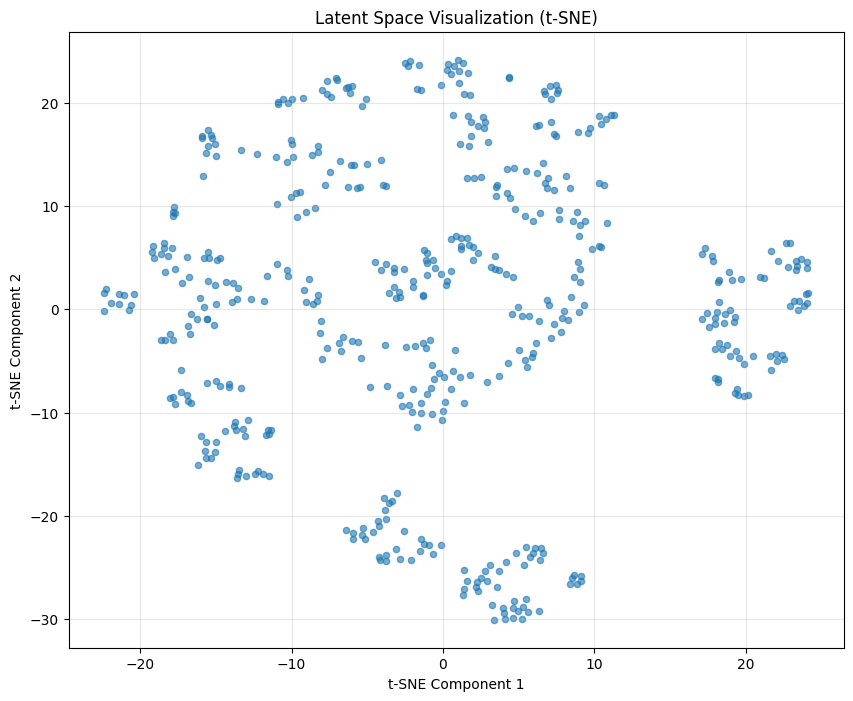

C:\Users\joobzm\AppData\Local\Temp\ipykernel_40956\57715676.py:396: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


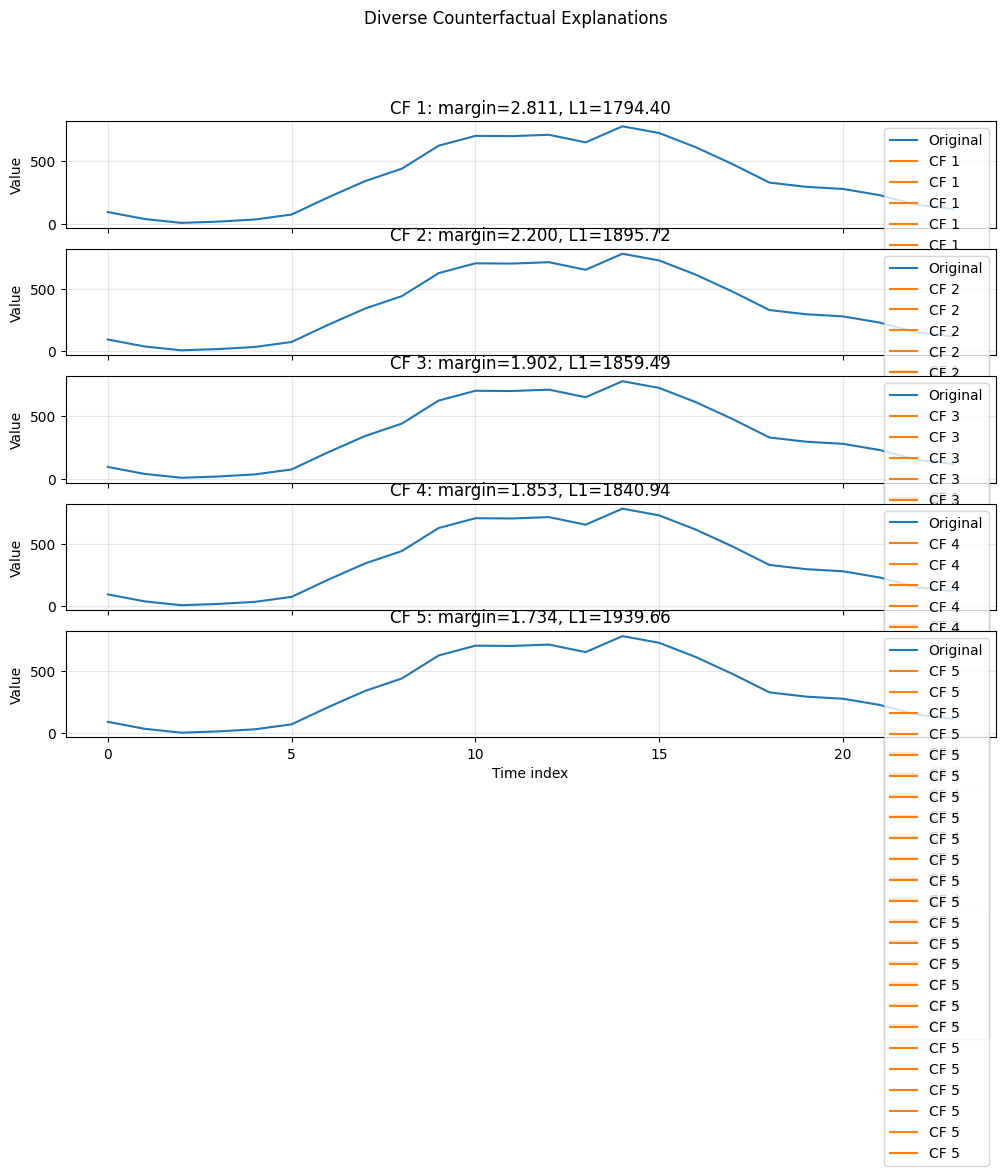

In [65]:
x_instance2 = x_instance
y_instance2 = y_instance

print("\n" + "=" * 50)
print("Generative-based Counterfactual Example")
print("=" * 50)

# Define instance for generative counterfactual generation
covered_indices = np.where((y_test >= y_lower) & (y_test <= y_upper))[0]

if len(covered_indices) > 0:
    idx_to_explain = random.choice(covered_indices)
    x_instance = X_test[idx_to_explain]
    y_instance = y_test[idx_to_explain]

    print(f"Selected instance {idx_to_explain} for generative counterfactual analysis.")
    print(f"Original input sequence (last 5 values): ...{np.round(x_instance[-5:], 2)}")
    print(f"True future value (y): {y_instance:.2f}")

    # Train VAE and generate counterfactuals
    gen_cf = GenerativeCounterfactualGenerator(model, device, alpha=alpha, latent_dim=16)
    gen_cf.train_vae(X_tr, epochs=300, batch_size=128, lr=1e-3, beta=0.1)

    gen_result = gen_cf.generate_diverse(
        x_instance,
        y_instance,
        n_samples=50,
        target_margin=0.5,
        diversity_weight=0.1,
        max_iter=500,
        lr=0.01,
        lower_bounds=0.0
    )
    print(gen_result["status"], "n_successful=", gen_result.get("n_successful"))

    # Visualize latent space
    latents_2d = gen_cf.plot_latent_space(X_tr, n_samples=500)

    # Plot diverse counterfactuals
    fig = gen_cf.plot_diverse_counterfactuals(gen_result, max_plot=5)
else:
    print("No covered instances found for counterfactual generation.")